In [270]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

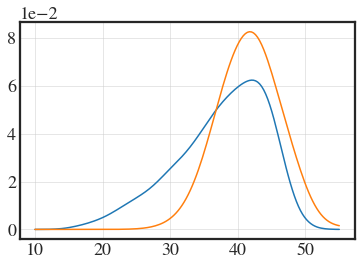

In [240]:
# Grid points in distance and inclination (theta_jn)
XX = np.loadtxt('./Inclination/figure_4/incl_grid_pts.dat.gz')
YY = np.loadtxt('./Inclination/figure_4/dist_grid_pts.dat.gz')

# Posterior PDF values for the marginal distributions shown in Figure 4
gw_Z = np.loadtxt('./Inclination/figure_4/volumetric_marginal_posterior_pdf.dat.gz')
em_Z = np.loadtxt('./Inclination/figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz')

theta_jns = XX[0, :]; 
dists = YY[:, 0]

d_theta_jn = theta_jns[1] - theta_jns[0]
ourprior = 1/np.sqrt(2*np.pi*7**2)*np.exp(-((180-XX)-21)**2/(2*7)**2)

#plt.plot(dists, d_theta_jn*np.sum(em_Z, axis=0), label='GW prior')
plt.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW prior')
y = d_theta_jn*np.sum(ourprior*gw_Z, axis=0)
norm = np.trapz(y, dists )
plt.plot(dists, y/norm, label='GW prior')


In [5]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
reset_plt(18,22)    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)


Lum_dist =  42.94003368335885 + 0.37065172463537976 - 0.37679570414075414
Lum_dist =  43.236892740377 + 0.40043370153550484 - 0.39103428410437857


### $d_L$ estimates

<ipython-input-483-83e350111aba>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(43.07-0.75, 43.07+0.75, alpha=0.3, color='grey', label='Sr$^+$ (Epoch 1+2)', edgecolor = 'k')


Lum_dist =  41.08425151733951 + 1.874923786210097 - 1.8206071103698136
0.17875423728813558
Lum_dist =  50.20441452807934 + 2.750078090347131 - 3.338307747729324
0.984412


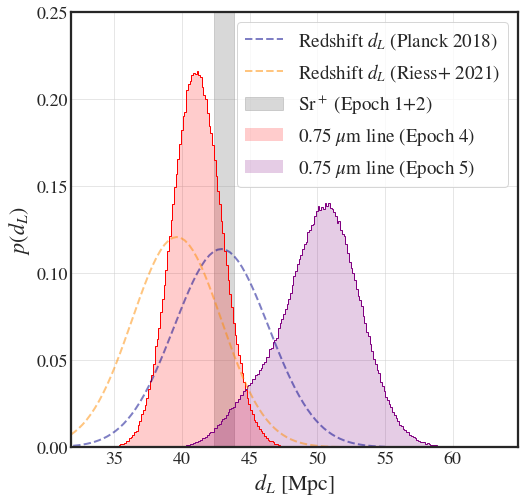

In [483]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.4, 4.40, 5.40]

#files = ["./Data/OB4/OB4_two_Pcygni_28x5000_lambda0_7550.pkl" , "./Data/OB5/OB5_two_Pcygni_28x5000_lambda0_7550.pkl"]
files = ["./Data/OB4/OB4_two_Pcygni_200x2500_lambda0free_7505.pkl" , "./Data/OB5/OB5_lambdafixed_7505_final_long.pkl"] 
#files = ["./Data/OB4/OB4_two_Pcygni_200x2500_lambda0free_7505.pkl" , "./Data/OB5/OB5_two_Pcygni_28x2000_lambda0_7500.pkl"] 


#files = ["./Data/OB4/OB4_two_Pcygni_28x5000.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 
         #"./Data/OB5/OB5_two_Pcygni_28x2000_lambda0_7500.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,8))
#combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(40, 46, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(40, 46, 100), 
#         combined, color='grey', ls='--', alpha=1)
#plt.fill_between( np.linspace(40, 46, 100), 
#         combined, color='grey', alpha=0.2, label='Sr II (Epoch 1+2)')

#plt.axvspan(mu-sigma, mu+sigma, alpha=0.5, color='grey', label='Sr$^+$ (Epoch 1+2)', edgecolor = 'k')
plt.axvspan(43.07-0.75, 43.07+0.75, alpha=0.3, color='grey', label='Sr$^+$ (Epoch 1+2)', edgecolor = 'k')


steady = [22*100, 25*10000, 22*1000, 28*1000, 250*1000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
#multi = [0.038, 0.04, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.015, 0.025])**2)**(1/2)      #dust extinction + flux calibration
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

scale = [0.02, 0.02, 0.02, 0.034, 0.034]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    idx = idx+3
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in); emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['v_phot_n'])*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['N']))
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
    dl = dl[:500000]
    
    plt.hist(dl, bins=250, histtype='step', density=True, range=(33,65), color=color_list[idx])
    plt.hist(dl, bins=250, histtype='stepfilled', alpha=0.2,
                 density=True, label='0.75 $\mu$m line (Epoch '+str(idx+1)+')', range=(33,65), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)

    print(len(dl[(dl>43.08-0.27)])/len(dl))
d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'$d_L$ [Mpc]'), plt.ylabel(r'$p(d_L)$') 
#plt.xlim(35, 47)
#plt.title('755 nm - P Cygni Line')

plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
plt.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift $d_L$ (Planck 2018)', 
         ls='--', color='darkblue', alpha=0.5, linewidth=2)
plt.plot(dists, 1/np.sqrt(2*np.pi*3.3**2)*np.exp(-(39.6-dists)**2/(2*3.3**2)), label='Redshift $d_L$ (Riess+ 2021)', 
         ls='--', color='darkorange'  , alpha=0.5, linewidth=2)


plt.xlim(31.8, 64.8)
plt.ylim(0, 0.25)
plt.legend(frameon=True, fontsize=19, loc=1)

#plt.savefig('Pictures/750_p_dist_inflated_5.png', dpi=300)

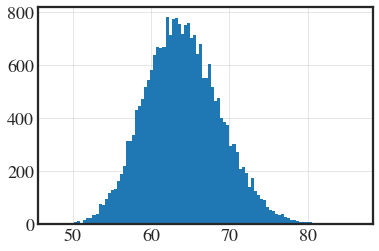

In [88]:
z    = np.random.normal(loc=0.00957, scale=0.00047, size=len(dl))

H0 = 1/dl*3e5*z*(1+1.53/2*z)
plt.hist(H0, bins=100); 

## $H_0$ constraints

<ipython-input-450-05b1b185369d>:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(67.36-0.54, 67.36+0.54, alpha=0.25, color='darkblue', edgecolor = 'k', label='Planck (2018)', hatch='//')
<ipython-input-450-05b1b185369d>:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(73.03-1.04, 73.03+1.04, alpha=0.25, color='darkorange', edgecolor = 'k', label='Riess+ (2021)', hatch='//')


H0 =  70.3584161139489 + 4.845065018603265 - 4.5659075292446545
H0 =  60.294101929982844 + 5.489454550280328 - 5.069827467009532


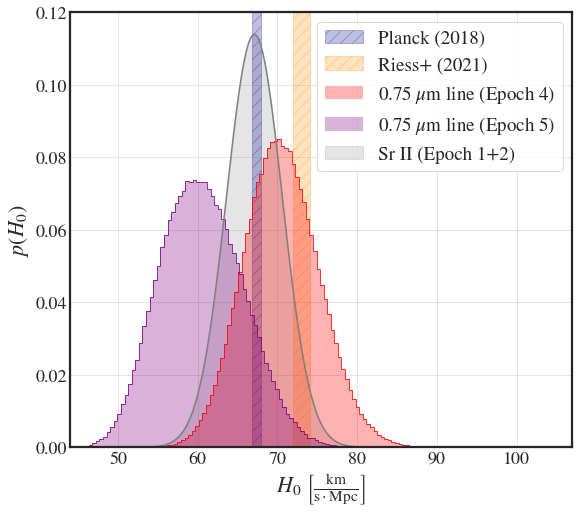

In [450]:
n_days = [1.43, 2.42, 3.4, 4.40, 5.40]

files = ["./Data/OB4/OB4_two_Pcygni_200x2500_lambda0free_7505.pkl" , "./Data/OB5/OB5_lambdafixed_7505_final_long.pkl"] 
#OB5_lambdafixed_7505_final
reset_plt(18,22)
plt.figure(figsize=(9,8))
plt.plot(x, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(x-67.1)**2/(2*3.5**2)), color='grey')
plt.fill_between(x, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(x-67.1)**2/(2*3.5**2)), 
                 color='grey', alpha=0.2, label='Sr II (Epoch 1+2)')

plt.axvspan(67.36-0.54, 67.36+0.54, alpha=0.25, color='darkblue', edgecolor = 'k', label='Planck (2018)', hatch='//')
plt.axvspan(73.03-1.04, 73.03+1.04, alpha=0.25, color='darkorange', edgecolor = 'k', label='Riess+ (2021)', hatch='//')

steady = [22*100, 25*10000, 22*1000, 28*1000, 25*10]

d_m, ds_1, ds_2 = [], [], []
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.015, 0.025])**2)**(1/2)      #dust extinction + flux calibration
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

scale = [0.02, 0.02, 0.02, 0.034, 0.034]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    idx = idx+3
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in); emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['v_phot_n'])*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['N']))
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
    
    #plt.hist(dl, bins=500, histtype='step', density=True, range=(33,65), color=color_list[idx])
    #plt.hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
    #             density=True, label='0.75 $\mu$m line (Epoch '+str(idx+1)+')', range=(33,65), color=color_list[idx])
    #temp.append( np.median(emcee_flatten['T']) )
    
    dl = dl[:500000]

    #print(len(dl[(dl>43.08-0.27)])/len(dl))
    z    = np.random.normal(loc=0.00957, scale=0.00047, size=len(dl))
    H0 = 1/dl*3e5*z*(1+1.53/2*z)
    plt.hist(H0, bins=100, histtype='step', alpha=0.8, density=True, color=color_list[idx]);
    plt.hist(H0, bins=100, histtype='stepfilled', alpha=0.3, density=True, color=color_list[idx], 
            label='0.75 $\mu$m line (Epoch '+str(idx+1)+')',);
    d1, d_l, d_h = np.median(H0), np.percentile(H0,15.9), np.percentile(H0,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('H0 = ', d1, '+', d_h-d1, '-', d1-d_l)

#d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
#z2 = np.random.normal(loc=0.00957, scale=0.00047, size=len(dists))
#plt.plot( (1/dists*3e5*0.00957*(1+1.53/2*0.00957)), d_theta_jn*np.sum(gw_Z, axis=1)/(1.4),
#         ls='--', color='green')
#plt.fill_between( (1/dists*3e5*0.00957*(1+1.53/2*0.00957)), d_theta_jn*np.sum(gw_Z, axis=1)/(1.4),
#         label='GW standard siren', ls='-', color='green', alpha=0.2)
#plt.hist(H_ny, bins=100, density=True, range=(50,100), color='green', histtype='step');
#plt.hist(H_ny2, bins=100, density=True);
#plt.plot(1/dists*3e5*0.00957*(1+1.53/2*0.00957), y/norm/1.4, label='GW standard siren + VLBI', ls='--', color='green')

plt.xlabel(r'$ H_0 \ \left[\frac{{\rm km}}{ {\rm s \cdot Mpc} } \right]$'), plt.ylabel(r'$p(H_0)$') 
#plt.xlim(35, 47)
#plt.title('755 nm - P Cygni Line')

plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
plt.xlim(44, 107)
plt.ylim(0, 0.12)
plt.legend(frameon=True, fontsize=19, loc=1)

plt.savefig('Pictures/750_p_H0_inflated_3.png', dpi=300)

In [377]:
1/np.sqrt(2*np.pi*3.5**2), 1/np.sqrt(2*np.pi*4.5**2)

(0.11398350868612361, 0.08865384008920726)

In [212]:
from scipy.interpolate import interp1d
size = 1000000
l = np.random.uniform(low=10, high=55, size=size)
prop = interp1d( dists , d_theta_jn*np.sum(gw_Z, axis=1) )(l)
l_ny = l[(np.random.uniform(low=0, high=max(d_theta_jn*np.sum(gw_Z, axis=1)), size=size)<prop)]

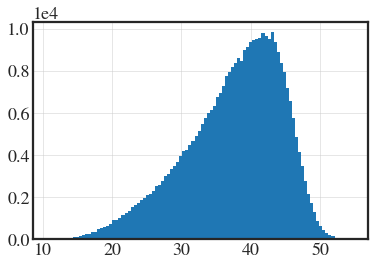

In [213]:
z2 = np.random.normal(loc=0.00957, scale=0.00045, size=len(l_ny))
plt.hist(l_ny, bins=100);

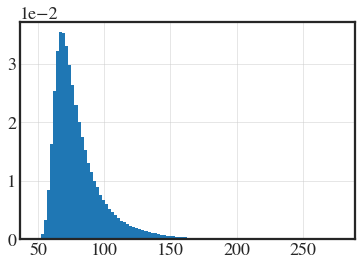

In [214]:
H_ny = 1/l_ny*3e5*z2*(1+1.53/2*z2)
plt.hist(H_ny, bins=100, density=True);

0.129826


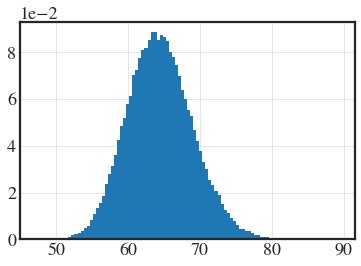

In [236]:
from scipy.interpolate import interp1d
size = 1000000
l = np.random.uniform(low=10, high=55, size=size)
prop = interp1d( dists , y )(l)
l_ny = l[(np.random.uniform(low=0, high=max(y), size=size)<prop)]

z3 = np.random.normal(loc=0.00957, scale=0.000457, size=len(l_ny))

#plt.hist(l_ny, bins=100);
H_ny2 = 1/l_ny*3e5*z3*(1+1.53/2*z3)
plt.hist(H_ny2, bins=100, density=True);
print(len(H_ny2)/size)

In [237]:
#for i in range(10):
#[(np.random.uniform(low=0, high=max(d_theta_jn*np.sum(gw_Z, axis=1)), size=10)<)]

In [223]:
np.trapz( d_theta_jn*np.sum(gw_Z, axis=1), dists)

1.0008156223253508

In [160]:
0.000457/0.00957

0.04775339602925809

In [159]:
dh = []
for z_i in np.random.normal(0.00957, scale=0.000457, size=10): 
    dh = (1/dists*3e5*z_i*(1+1.53/2*z_i)), 
    
    scipy.interpolate.inter1d(d_theta_jn*np.sum(gw_Z, axis=1), )

0.009416823671905153
0.00875757218790593
0.00993017004302793
0.009588230128795542
0.008921099808124458
0.009478252775848194
0.01021725937614061
0.009373860580674749
0.009892876201875796
0.009668355106640492


array([1.65418062e-07, 6.26344287e-07, 1.85856006e-06, 4.49186175e-06,
       9.28904086e-06, 1.72738260e-05, 2.98904306e-05, 4.87434679e-05,
       7.50157170e-05, 1.09299243e-04, 1.52146876e-04, 2.04653301e-04,
       2.68434252e-04, 3.45467234e-04, 4.38159733e-04, 5.48796043e-04,
       6.78090934e-04, 8.24368282e-04, 9.84519919e-04, 1.15589429e-03,
       1.33745195e-03, 1.52950821e-03, 1.73280329e-03, 1.94789008e-03,
       2.17504995e-03, 2.41448822e-03, 2.66663339e-03, 2.93241702e-03,
       3.21329498e-03, 3.51084366e-03, 3.82631499e-03, 4.16073191e-03,
       4.51527933e-03, 4.89128652e-03, 5.28981244e-03, 5.71128900e-03,
       6.15532705e-03, 6.62060242e-03, 7.10485770e-03, 7.60506416e-03,
       8.11770780e-03, 8.63913517e-03, 9.16590157e-03, 9.69507328e-03,
       1.02244493e-02, 1.07526902e-02, 1.12793660e-02, 1.18049522e-02,
       1.23308063e-02, 1.28591512e-02, 1.33930682e-02, 1.39364766e-02,
       1.44940575e-02, 1.50710685e-02, 1.56730100e-02, 1.63051334e-02,
      

In [261]:
pickle_in = open("./Data/OB4/OB4_two_Pcygni_200x2500_lambda0free_7505.pkl","rb")
emcee_res = pickle.load(pickle_in); flat = emcee_res.flatchain

In [262]:
emcee_flatten

,T,N,vphot,vmax,tau,ve,occult,amp1,amp2,v_out_n,v_phot_n,tau_n,lambda_n,ve_n
0,3234.921640,3.120549e-29,0.176558,0.231142,0.385228,10.766982,7.714946,0.963745,0.922086,0.182815,0.156458,0.573886,7505.111026,1.966272
1,3234.762968,3.120396e-29,0.176564,0.231147,0.385197,10.770089,7.712751,0.963929,0.922140,0.182829,0.156449,0.573965,7505.260778,1.966163
2,3234.561585,3.121052e-29,0.176543,0.231131,0.385124,10.767763,7.712436,0.963838,0.921882,0.182835,0.156475,0.574057,7504.483938,1.966041
3,3234.154602,3.121268e-29,0.176568,0.231152,0.385202,10.771723,7.713692,0.963878,0.922084,0.182813,0.156417,0.573984,7505.196229,1.966463
4,3234.669467,3.121043e-29,0.176572,0.231188,0.385166,10.770845,7.714001,0.963787,0.922104,0.182818,0.156453,0.574093,7507.023136,1.966064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,3233.693548,3.117182e-29,0.175265,0.230936,0.380546,6.548286,7.761952,0.970022,0.930163,0.182132,0.155347,0.508313,7505.804541,4.060297
499996,3235.859709,3.107462e-29,0.176134,0.232342,0.367406,14.380070,7.873395,0.976670,0.932258,0.183713,0.156882,0.520315,7515.053652,2.550436
499997,3236.463534,3.109176e-29,0.177506,0.231583,0.387074,8.460256,7.828066,0.970928,0.921948,0.181375,0.155391,0.529823,7507.790057,5.717975
499998,3233.739273,3.120051e-29,0.178927,0.232074,0.390962,11.448209,7.878360,0.973556,0.926391,0.186995,0.158757,0.487811,7520.248177,5.224129


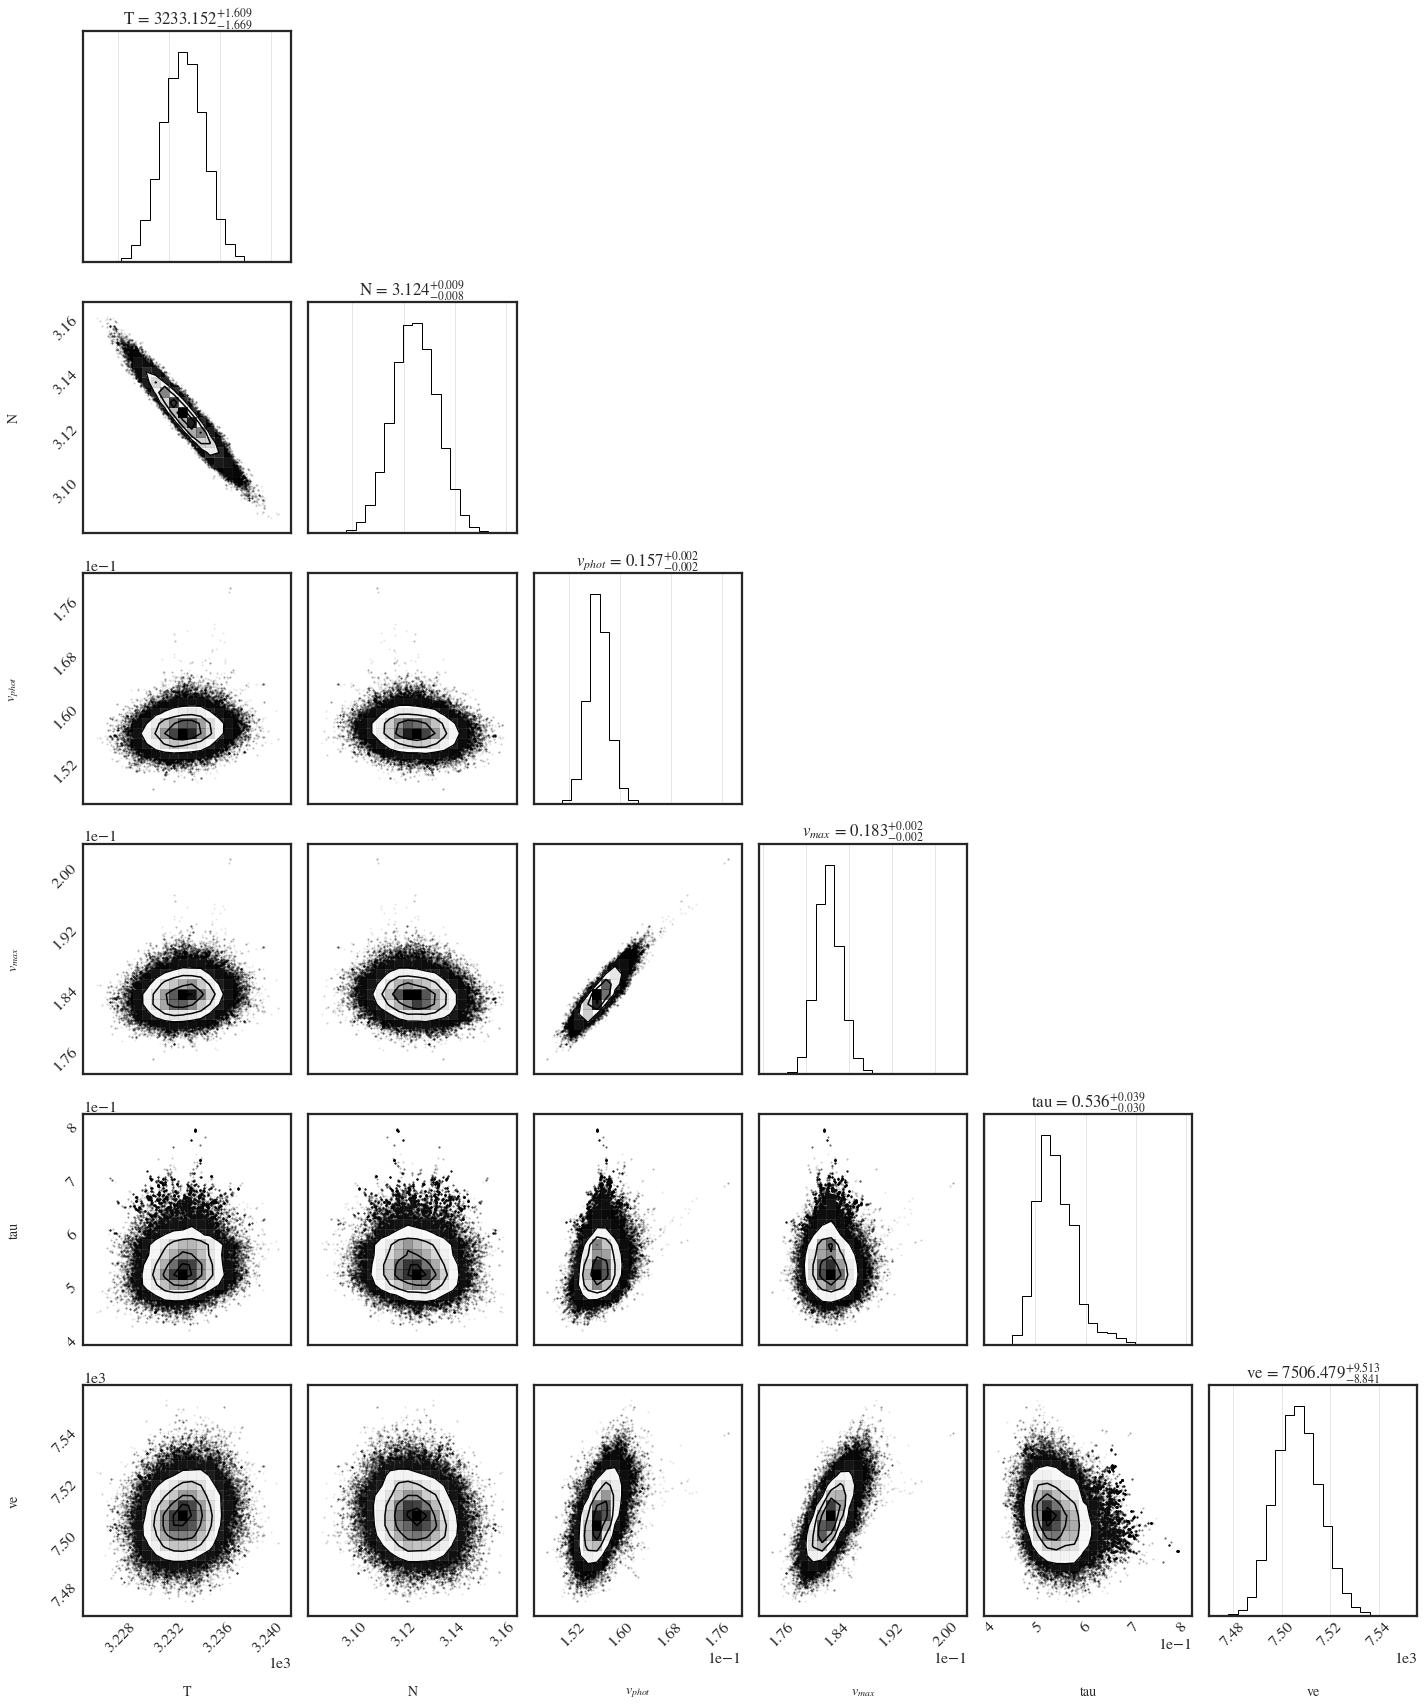

In [265]:
import corner

n_box = 6
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 1000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['v_phot_n'][rej:], flat['v_out_n'][rej:], 
                         flat['tau_n'][rej:], flat['lambda_n'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

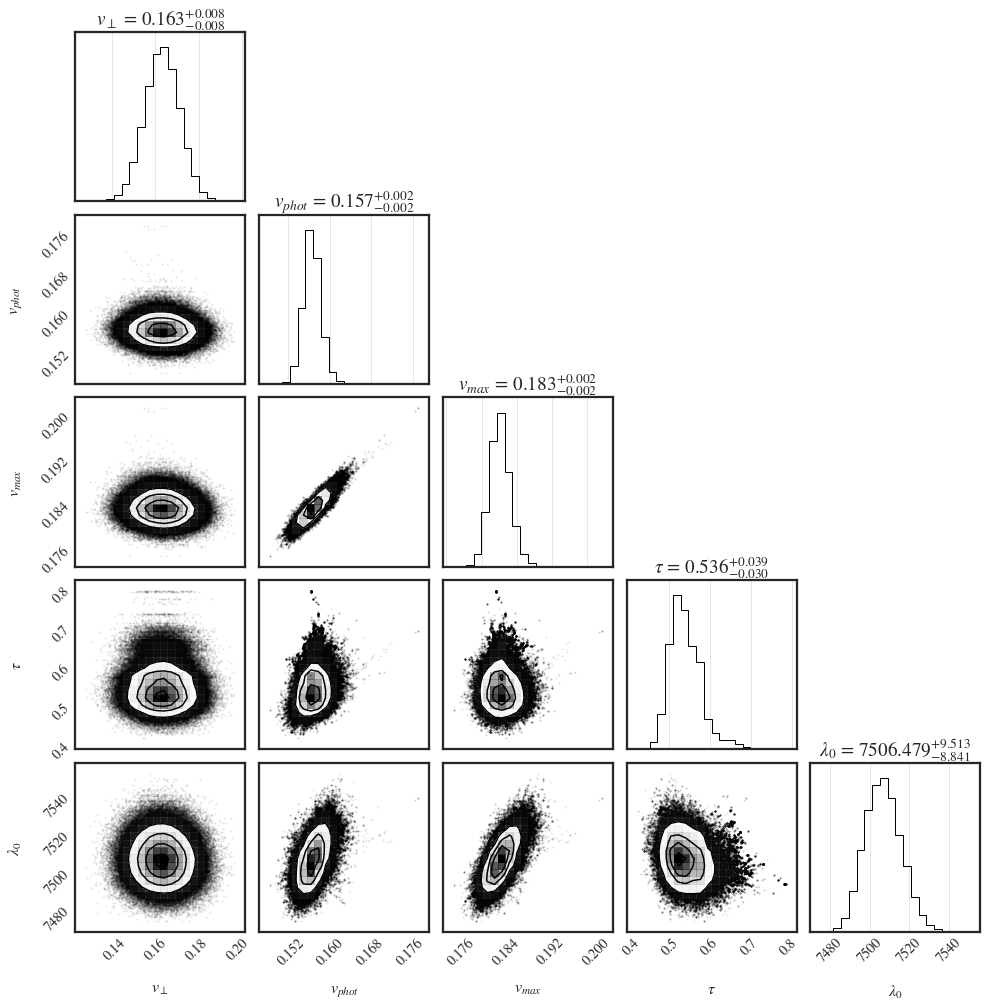

In [352]:
import corner

n_box = 5
fig,ax = plt.subplots(figsize=(14,14.3),nrows=n_box,ncols=n_box)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
#ax = ax.flatten()
rej = 1000
reset_plt(14, 16)
corner.corner( np.array([v_sn_1[rej:], flat['v_phot_n'][rej:], flat['v_out_n'][rej:], 
                         flat['tau_n'][rej:], flat['lambda_n'][rej:]]).T, 
              labels=[r'$v_{\perp}$',r'$v_{phot}$', r'$v_{max}$',r'$\tau$','$\lambda_0$'], fig=fig, 
              show_titles=True, title_fmt = '.3f'); 
plt.tight_layout() 

ax[4][0].ticklabel_format(style='plain')
ax[4][1].ticklabel_format(axis='x', style='plain'), #ax[4][1].set_yticks(fontsize=14)
ax[4][2].ticklabel_format(axis='x', style='plain')
ax[4][3].ticklabel_format(axis='x', style='plain'), 
ax[4][4].ticklabel_format(axis='x', style='plain')

ax[1][0].ticklabel_format(axis='y', style='plain')
ax[2][0].ticklabel_format(axis='y', style='plain'), 
ax[3][0].ticklabel_format(axis='y', style='plain')
fig.subplots_adjust(wspace=0.08, hspace=0.08)

plt.savefig('Pictures/750_4th_posterior_param.png', dpi=300)

In [298]:
#flat['N'][rej:]

N_1      = ( np.array(flat['N'])     )
v_phot_1 = ( np.array(flat['v_phot_n']) )
R_1 = np.sqrt( np.array(N_1)*10**7  ) *(np.random.normal(42.8, scale=0.049*42.8, size=len(N_1))*3.086e+24)
v_sn_1 = R_1/4.4/(24*3600*3e10)/inter(v_phot_1)**2

In [299]:
v_sn_1

array([0.15402215, 0.14894201, 0.15300406, ..., 0.17896319, 0.16173638,
       0.17157778])

In [296]:
0.00047/0.00957

0.04911180773249738

In [301]:
0.005/0.163

0.03067484662576687

In [396]:
pickle_in = open("./Data/OB5/OB5_lambdafixed_7505_final_long.pkl","rb") #OB5_lambdafixed_7505_final
emcee_res = pickle.load(pickle_in); flat = emcee_res.flatchain

In [397]:
len(flat)

1000000

In [393]:
emcee_res.params

name,value,standard error,relative error,initial value,min,max,vary
T,3098.25828,3.24901696,(0.10%),3096.876188581602,2500.00000,7500.00000,True
N,3.5111e-29,1.7174e-31,(0.49%),3.516071350443972e-29,-inf,inf,True
vphot,0.14995266,0.00123192,(0.82%),0.15505000366732652,0.00000000,1.00000000,True
vmax,0.24004334,0.00186629,(0.78%),0.2415138427881532,0.00000000,1.00000000,True
t0,466560.000,,(0.78%),466560,-inf,inf,False
tau,0.31931284,0.04791980,(15.01%),0.36087824837662275,0.00000000,10.0000000,True
vref,0.00000000,,(15.01%),0.0,0.00000000,1.00000000,False
ve,0.17952012,0.02711254,(15.10%),0.17012692264150672,0.00000000,20.0000000,True
occult,19.8903682,0.08946608,(0.45%),19.864194217092106,0.10000000,20.0000000,True
amp1,1.18283689,0.00875894,(0.74%),1.1816083773317823,0.01000000,5.00000000,True


In [398]:
#flat['N'][rej:]

N_1      = ( np.array(flat['N'])     )
v_phot_1 = ( np.array(flat['vphot']) )
R_1 = np.sqrt( np.array(N_1)*10**7  ) *(np.random.normal(42.8, scale=0.049*42.8, size=len(N_1))*3.086e+24)
v_sn_1 = R_1/5.4/(24*3600*3e10)/inter(v_phot_1)**2

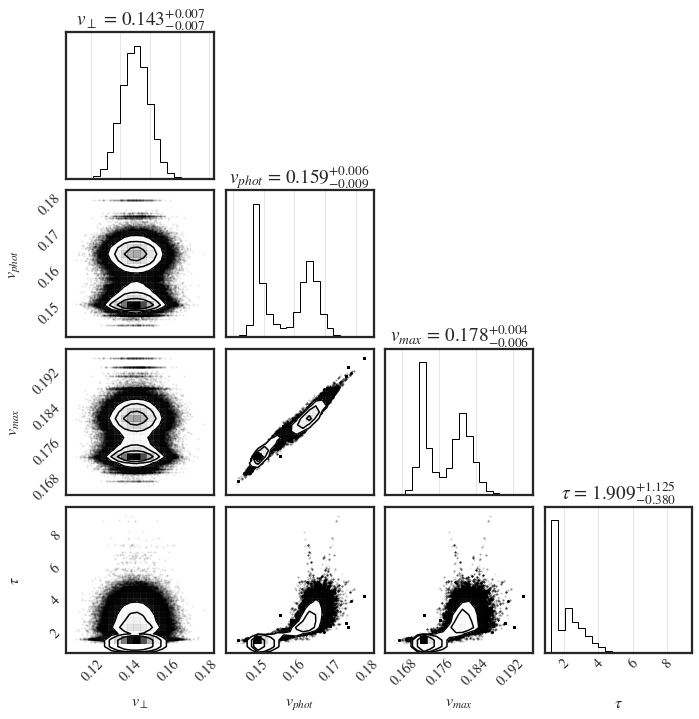

In [424]:
import corner

n_box = 4
fig,ax = plt.subplots(figsize=(10,10.3),nrows=n_box,ncols=n_box)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
#ax = ax.flatten()
rej = 1000
reset_plt(14, 16)
corner.corner( np.array([v_sn_1[rej:500000], flat['v_phot_n'][rej:500000], flat['v_out_n'][rej:500000], 
                         flat['tau_n'][rej:500000]]).T, 
              labels=[r'$v_{\perp}$',r'$v_{phot}$', r'$v_{max}$',r'$\tau$'], fig=fig, 
              show_titles=True, title_fmt = '.3f'); 
plt.tight_layout() 

ax[3][0].ticklabel_format(style='plain')
ax[3][1].ticklabel_format(axis='x', style='plain'), #ax[4][1].set_yticks(fontsize=14)
ax[3][2].ticklabel_format(axis='x', style='plain')
ax[3][3].ticklabel_format(axis='x', style='plain'), 
#ax[4][4].ticklabel_format(axis='x', style='plain')

ax[1][0].ticklabel_format(axis='y', style='plain')
ax[2][0].ticklabel_format(axis='y', style='plain'), 
ax[3][0].ticklabel_format(axis='y', style='plain')
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#plt.savefig('Pictures/750_5th_posterior_param.png', dpi=300)

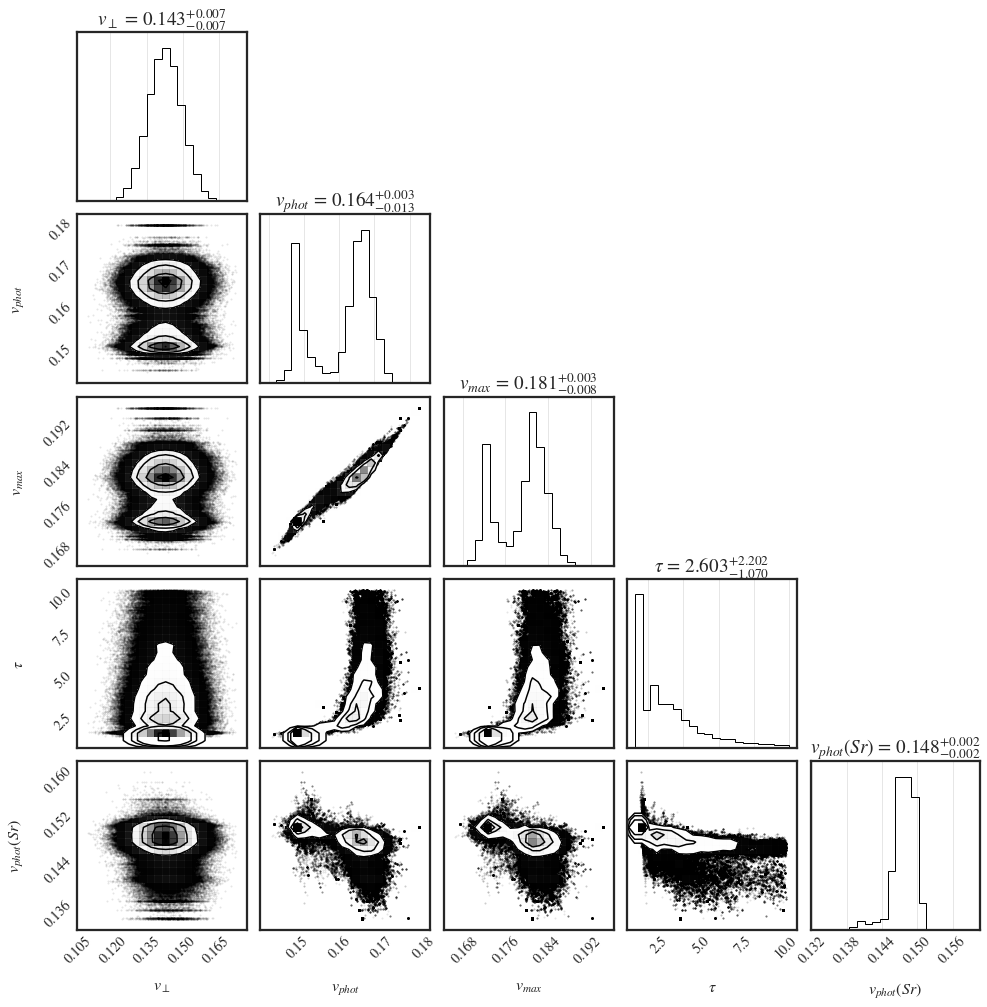

In [389]:
import corner

n_box = 5
fig,ax = plt.subplots(figsize=(14,14.3),nrows=n_box,ncols=n_box)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
#ax = ax.flatten()
rej = 1000
reset_plt(14, 16)
corner.corner( np.array([v_sn_1[rej:], flat['v_phot_n'][rej:], flat['v_out_n'][rej:], 
                         flat['tau_n'][rej:], flat['vphot'][rej:]]).T, 
              labels=[r'$v_{\perp}$',r'$v_{phot}$', r'$v_{max}$',r'$\tau$', r'$v_{phot}(Sr)$'], fig=fig, 
              show_titles=True, title_fmt = '.3f'); 
plt.tight_layout() 

ax[4][0].ticklabel_format(style='plain')
ax[4][1].ticklabel_format(axis='x', style='plain'), #ax[4][1].set_yticks(fontsize=14)
ax[4][2].ticklabel_format(axis='x', style='plain')
ax[4][3].ticklabel_format(axis='x', style='plain'), 
ax[4][4].ticklabel_format(axis='x', style='plain')

ax[1][0].ticklabel_format(axis='y', style='plain')
ax[2][0].ticklabel_format(axis='y', style='plain'), 
ax[3][0].ticklabel_format(axis='y', style='plain')
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#plt.savefig('Pictures/750_4th_posterior_param.png', dpi=300)

In [388]:
(0.143-0.164)/(0.143+0.164)

-0.06840390879478833

In [390]:
pickle_in = open("./Data/OB5/OB5_two_Pcygni_30x2000_lambda0free_7685.pkl","rb")
emcee_res = pickle.load(pickle_in); flat = emcee_res.flatchain
#flat['N'][rej:]

N_1      = ( np.array(flat['N'])     )
v_phot_1 = ( np.array(flat['vphot']) )
R_1 = np.sqrt( np.array(N_1)*10**7  ) *(np.random.normal(42.8, scale=0.049*42.8, size=len(N_1))*3.086e+24)
v_sn_1 = R_1/5.4/(24*3600*3e10)/inter(v_phot_1)**2

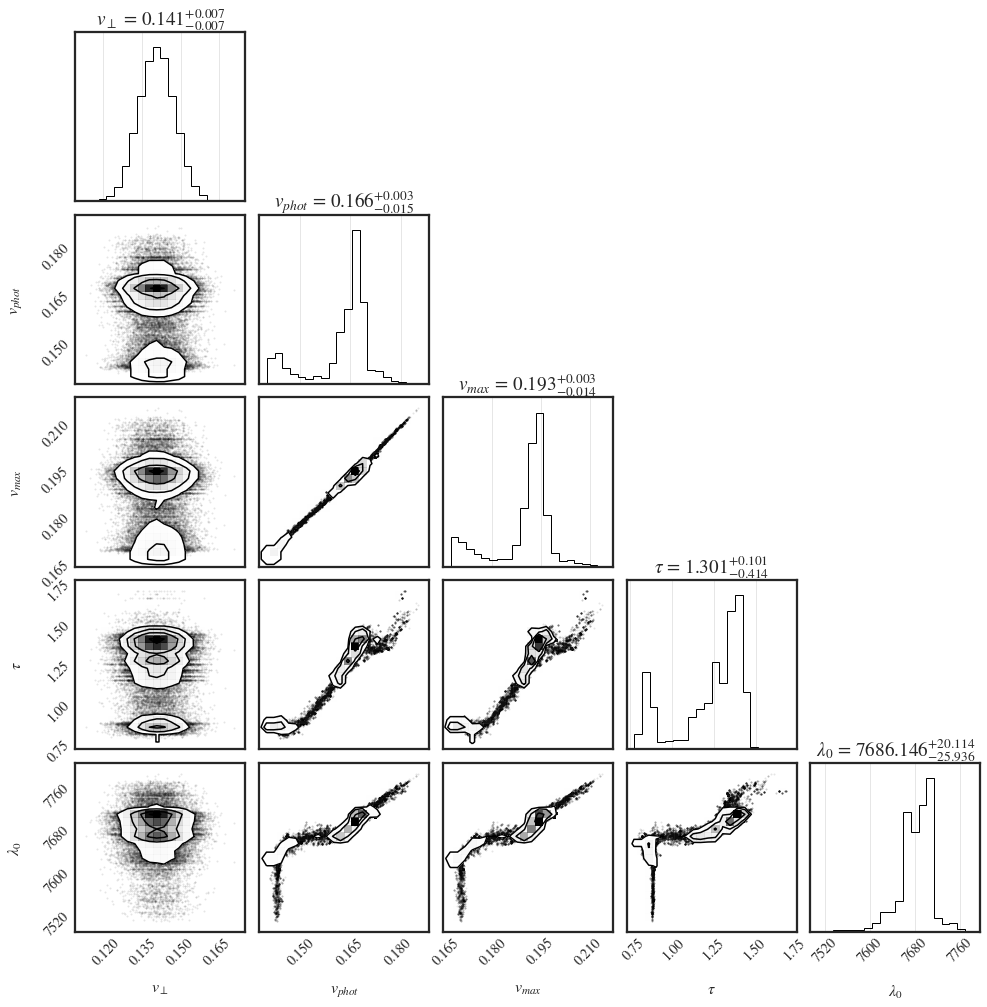

In [391]:
import corner

n_box = 5
fig,ax = plt.subplots(figsize=(14,14.3),nrows=n_box,ncols=n_box)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
#ax = ax.flatten()
rej = 1000
reset_plt(14, 16)
corner.corner( np.array([v_sn_1[rej:], flat['v_phot_n'][rej:], flat['v_out_n'][rej:], 
                         flat['tau_n'][rej:], flat['lambda_n'][rej:]]).T, 
              labels=[r'$v_{\perp}$',r'$v_{phot}$', r'$v_{max}$',r'$\tau$','$\lambda_0$'], fig=fig, 
              show_titles=True, title_fmt = '.3f'); 
plt.tight_layout() 

ax[4][0].ticklabel_format(style='plain')
ax[4][1].ticklabel_format(axis='x', style='plain'), #ax[4][1].set_yticks(fontsize=14)
ax[4][2].ticklabel_format(axis='x', style='plain')
ax[4][3].ticklabel_format(axis='x', style='plain'), 
ax[4][4].ticklabel_format(axis='x', style='plain')

ax[1][0].ticklabel_format(axis='y', style='plain')
ax[2][0].ticklabel_format(axis='y', style='plain'), 
ax[3][0].ticklabel_format(axis='y', style='plain')
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#plt.savefig('Pictures/750_4th_posterior_param.png', dpi=300)

In [ ]:
len()